# Image collections, cloud masking, and image collection filtering

* **Special requirements:** A Google account, access to Google Earth Engine.
* **Prerequisites:** You should have completed the "Week 2 - Prac 1" notebook.


## Background

There are many ways to remove clouds and cloud shadows from images, however not all algorithms to do this are available in GEE. In this notebook you'll learn to remove (i.e. 'filter') clouds and cloud shadows from Landsat images using available algorithms. 

Likewise, sometimes we need images from one region of interest (ROI) or from a certain date or date range. Here we'll see how to search the Landsat archive to filter for those images, but you can do the same with other optical sensors such as Sentinel 2 or MODIS (although filtering methods will vary).


***

## Aims of the practical session

This practical has three aims:
1. to demonstrate how to filter clouds and other poor quality pixels from Landsat and Sentinel-2 images,
2. to demonstrate how to filter image collections by location, and
3. to demonstrate how to filter images by date.

***

## Description

In this notebook you'll learn to remove (i.e. 'filter') clouds filter images by location and by date. 

1. Create a Region of Interest (ROI). This can be a polygon or a single point.
2. load an image collection from the Canberra region (filter by location based on created ROI) and visualize some images corresponding to the year 2022 (filter by date), and
3. remove the clouds and evaluate the result.

**Challenge:**

* Replicate the workflow for the Amazon region and compare the results to check the effectiveness of different filtering approaches in the different regions.

<div class="alert alert-block alert-warning">
<b>Assessment:</b> Once you finish the practical and the excercises, remember to submit your notebook through Wattle.
Challenges are optional and will not be part of the assessment.
</div>

***

## Getting started


### Load packages

Import Python packages that are used for the analysis.


In [1]:
%matplotlib inline

import geemap as gmap
import ee
import matplotlib.pyplot as plt

### Connect to Google Earth Engine (GEE)

Connect to the GEE so we can access GEE datasets and computing assets.
You may be required to input your Google account name and password. Please keep those safe and don't share them with anyone.

In [2]:
m = gmap.Map()

Enter verification code:  4/1AdQt8qjqpii84gxF0h5jQwDAc4iZ25fxqtc24_u2Dbbyn4vhT5Z0QTOKd-o



Successfully saved authorization token.


***

## 1. Load top-of-atmopshere and surface reflectance satellite images over the ACT region.


Use a Landsat 8 image.

First, let's display the image in 'True color'. True Color means that we display the Red, Green, and Blue (RGB) bands. This makes it more intuitive to distinguish the features in the image.

You can find more information about the spectral bands of the Landsat 8 sensor [here](https://www.usgs.gov/media/images/landsat-8-band-designations)

> Note Landsat datasets need to be rescaled from the `int` datatype they're stored in to a `floating` point dataype using specific scaling coefficients. Any time you load Landsat Collection 2 data these coefficients **must be applied**

In [3]:
def rescale_landsatC2(image):
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True)

In [4]:
# We give the 'center' location, and a 'zoom' level.
Map = gmap.Map(center=[-35.2041, 149.2721], zoom=9)

# Search for a specific landsat 8 image collection 1
LS_toa = ee.Image('LANDSAT/LC08/C02/T1_TOA/LC08_090084_20210219')

# Now we select the bands we want to display for the collection 1 image
vis_toa = {'bands': ['B4', 'B3', 'B2'],
              'min': 0,
              'max': 0.4}

# Search for a landsat 8 image collection 2
LS_C2 = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_090085_20210118')
LS_C2 = rescale_landsatC2(LS_C2)

# Now we select the bands we want to display for the collection 2 image
vis_ls = {'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
              'min': 0,
              'max': 0.4}

# Add the landsat 8 image to our map
Map.addLayer(LS_toa, vis_toa, 'TOA Landsat 8')
Map.addLayer(LS_C2, vis_ls, 'Surface reflectance Landsat 8')
Map.addLayerControl()
Map

Map(center=[-35.2041, 149.2721], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

### <a name="ex1"></a> Exercise 1 - Answer the following questions using the information above

<div class="alert alert-block alert-danger">
    
1. Briefly explain why the two images look different despite coming from the same sensor?
    
2. What algorithms and processes are applied to the raw/top-of-atmopshere satellite images to create the Landsat 8-9 Collection 2 Surface Reflectance product'? Explore the USGS [Landsat Collection 2 Surface Relfectance product documentation](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance) and [GEE guides](https://developers.google.com/earth-engine/guides/landsat) to answer this question 
    
3. Briefly descibe the Landsat Collections and Levels taxonomy. Start with the documentation [here](https://www.usgs.gov/landsat-missions/landsat-collections)
    
Answer these questions in the cell below.
</div>

.

## 2. Cloud Masking

These images looks very clear. As you zoom in and out, you can easily distinguish some landscape features.

However, not all satellite images are as good as this one. So lets' look at another image and its metadata:


In [5]:
# Get a Landsat Image
cloudy = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_090084_20190622') 
cloudy = rescale_landsatC2(cloudy)

Map1 = gmap.Map(center=[-35.2041, 149.2721], zoom=9)

# Add the image to the map
Map1.addLayer(cloudy, vis_ls, 'a cloudy Landsat 8 image')

# Display the map
Map1

Map(center=[-35.2041, 149.2721], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

There are several ways to remove clouds from satellite images, but for now, you must know that (*most*) Landsat images has a pixel quality band called `pixel_qa` or `QA_PIXEL`.

**GEE TIP:** again, be mindful of the image(s) you're loading; for example, Landsat 4,5, and 7 will have different coefficients to Landsat 8 and 9. If you get any errors in applying coulds filtering, inspect the metadata to search for the information on the image you are downloading and adjust your code accordingly.

You can learn more about the contents of the `pixel_qa` band [here](https://www.usgs.gov/landsat-missions/landsat-collection-2-quality-assessment-bands)

Ok, let's try to remove the clouds from the `cloudy` and the `clear` images. To do that, we'll have to create a function, and then we'll apply that function to the images.

In [6]:
# This example demonstrates the use of the Landsat 8 Collection 2, Level 2
# QA_PIXEL band (CFMask) to mask unwanted pixels.
# First, we define a function to mask the clouds .

def cloudMaskL8Collection2(image):
  # Bit 0 - Fill
  # Bit 1 - Dilated Cloud
  # Bit 2 - Cirrus
  # Bit 3 - Cloud
  # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111',2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

  # Replace the original bands with the scaled ones and apply the masks.
    return image.updateMask(qaMask) \
          .updateMask(saturationMask)

Let's apply the function and display the images to see the result.

Change the opacity of the images so you can see the differences more clearly.

In [7]:
Map2 = gmap.Map(center=[-35.2041, 149.2721], zoom=9)

# Apply the function to the images
clearMasked = cloudMaskL8Collection2(LS_C2)
cloudyMasked = cloudMaskL8Collection2(cloudy)

# Display the results.
Map2.addLayer(clearMasked, vis_ls,'clearMasked')
Map2.addLayer(cloudyMasked, vis_ls,'cloudyMasked')
Map2.addLayer(LS_C2, vis_ls, 'a clear Landsat 8 image')
Map2.addLayer(cloudy, vis_ls, 'a cloudy Landsat 8 image')
Map2.addLayerControl()
Map2

Map(center=[-35.2041, 149.2721], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

It's your turn to code.

### <a name="ex2"></a> Exercise 2 - Create a cloud masking function for a Sentinel-2 

<div class="alert alert-block alert-danger">

In the map, load both an unmasked and cloud masked sentinel-2 image.
    
</div>

> Hint: The Sentinel-2 data catalog page for Sentinel-2 is [here](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR).  Check if you need to rescale the values in addition to applying a cloud mask

In [ ]:
# Your code goes here.

def cloudMaskSentinel2(image):
  
    return 

In [ ]:
Map3 = gmap.Map(center=[-35.2041, 149.2721], zoom=9)



Map3

***

## 3. Add multiple images at once (i.e. add ImageCollection)

We are now going to use the `ImageCollection` command to call the Landsat 8 image collection.

This shows *all available* Landsat 8 images for all the globe. Under some circumstances this could be good, but we don't want (or need) all those images.

> Note: When applying functions to `ImageCollections` we must use the `ImageCollection.map(func)` method, this is slightly different than when we apply functions to an `Image` (see the examples above)

In [8]:
Map4 = gmap.Map(center=[-35.2041, 149.2721], zoom=8)

# Map the function over one year of data.
collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
collection = collection.map(rescale_landsatC2)

# Display the results.
Map4.addLayer(collection, vis_ls, 'collection')
Map4.addLayerControl()
Map4

Map(center=[-35.2041, 149.2721], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

But we dont need *all* Landsat 8 images; we only want those directly above the ACT.
Let's filter the image collection using a polygon (i.e. Region of Interest)

You can create a ROI using the menus on the left of your map (see below), or you can upload your own vector file (not shown in this notebook).
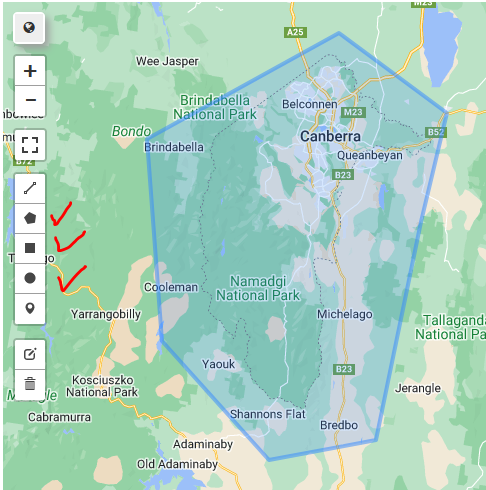

Once we have a polygon, we need to extract its coordinates so we can tell GEE that we want *only the images that intersect that polygon*. We do that by using the `user_roi` command:

In [9]:
Map4.user_roi.getInfo()
# Note that this will be different for you because my polygon is not the same as yours.
# Also note the 'BaseMap' you're using to create the polygon

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[148.969116, -35.443069],
   [148.969116, -35.129194],
   [149.298706, -35.129194],
   [149.298706, -35.443069],
   [148.969116, -35.443069]]]}

## Filter an image collection by location

To filter the image, we use the `filterBounds` method in GEE. Read more [here](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-filterbounds)

In [10]:
Map5 = gmap.Map(center=[-35,149], zoom=8)

# Filter the image collection to select only the images within the ROI boundaries
filtered = collection.filterBounds(Map4.user_roi.getInfo())

# Add all landsat 8 images to our map
Map5.addLayer(filtered, vis_ls, 'only images from the ACT')

Map5

Map(center=[-35, 149], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [11]:
# we can see how many Landsat 8 images there are over the ACT:
print(f'there are: {filtered.size().getInfo()} Landsat 8 images that intersect our ROI')

there are: 764 Landsat 8 images that intersect our ROI


Now let's use a point to filter the image collection:

In [12]:
Map5 = gmap.Map(center=[-35,149], zoom=8)

# Create a point with set coordinates
point = ee.Geometry.Point([149.158494, -35.156445])
    
# Filter the image collection to select only the images within the ROI boundaries
filteredByPoint = collection.filterBounds(point)

# Add all landsat 8 images to our map
Map5.addLayer(filteredByPoint, {}, 'Landsat 8 images that intersect our point')
Map5.addLayer(point,{},'The point')
Map5

Map(center=[-35, 149], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

***

## Filter an image collection by date

Similar to `filterBounds`, GEE has a `filterDate` method. Let's see it in action.
You can learn more [here](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-filterdate)

In [13]:
Map6 = gmap.Map(center=[-35,149], zoom=8)

# Note we're still using the whole Landsat 8 collection from above, and
# the same ROI.
filteredByDate = collection \
                        .filterBounds(Map4.user_roi.getInfo()) \
                        .filterDate('2021', '2022')

# we can see how many Landsat 8 images were collected :
print(f'there are: {filteredByDate.size().getInfo()} Landsat 8 images over the ACT for 2019-2020')

Map6.addLayer(filteredByDate, vis_ls, 'Landsat 8 images over the ACT for 2019-2020')

Map6

there are: 84 Landsat 8 images over the ACT for 2019-2020


Map(center=[-35, 149], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

But we can be much more specific than just giving the years, we can filter the image Collection using the years and months, or we can use specific dates.

## Exercise 3 - Filter by date
<div class="alert alert-block alert-danger">
    
In the cells below, try using the following:
* `startDate = '2014-01'`,  `endDate = '2014-12'`, and
    
* `startDate = '2021-04-16'`,  `endDate = '2021-04-30'`
</div>




In [ ]:
# Your code goes here.


In [ ]:
# Your code goes here.


***

## Exercise 4 - Put everything together

<div class="alert alert-block alert-danger">

It's time to put all the things we've learned together:

1. Load a _rescaled_ Landsat 8 image collection
    
2. Filter the collection by any date,
    
3. Filter the collection by location
    
4. Remove the clouds of the image Collection, and add the masked collection to the map.
    
</div>

***

## Summary

In this notebook you have learned about:
- Different Landsat images, by loading TOA and Surface Reflectance images.
- How to mask satellite images using per-pixel quality flags (clouds etc)
- Single images and image collections. A single image is a single 'photo' of earth, while image collections are all the images taken by a single satellite, and processed to a certain quality.
- Filtering images and image collections by date and location. You did this by using specific dates, specific months, or just the years you're interested in. You also drew polygons (regions of interest) and gathered the images that intersected those regions of interest.

***

## References and useful readings

- Chapters 12, 13, and 14 form the "Earth Observation: Data, Processing and Applications" book, Volume 1A: Data—Basics and Acquisition". Available through Wattle, or  http://www.crcsi.com.au/earth-observation-series.
- https://geemap.org/
- http://dx.doi.org/10.1016/j.rse.2015.11.032
- https://doi.org/10.3390/rs1030184
- https://doi.org/10.1016/j.rse.2014.02.001
- 10.1016/j.rse.2019.05.024 

***

## Additional information

**Sources:** The code in this notebook as several sources, including:
https://github.com/giswqs/geemap; 

**License:** Some of the code in this notebook was initially created by [Qiusheng Wu](https://github.com/giswqs), and has been modified by Nicolas Younes. The code in this notebook is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/), and an [MIT Licence](https://mit-license.org/). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle course forum

**Last modified:** August 2022

***